<a href="https://colab.research.google.com/github/thanhquye/Traffic-sign-classification/blob/main/Traffic_sign_classification_and_bbox_model_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import os
import cv2
from PIL import Image

from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

import timm
import torch
import torch.nn as nn
import torch.optim as optim

**Load data**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Machine_Leaning/Project/Data/data'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Machine_Leaning/Project/Data/data


In [4]:
df = pd.read_csv('Train.csv')

df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        # get img
        img_path = '/content/gdrive/MyDrive/Machine_Leaning/Project/Data/data/' + self.dataframe.iloc[idx]['Path']
        img = Image.open(img_path).convert('RGB')

        # get bbox
        row = self.dataframe.iloc[idx]
        xmin = row['Roi.X1']
        ymin = row['Roi.Y1']
        xmax = row['Roi.X2']
        ymax = row['Roi.Y2']
        bbox = [[xmin, ymin, xmax,ymax]]

        # get class
        class_id = self.dataframe.iloc[idx]['ClassId']

        if self.transform:
            augmented = self.transform(image=np.array(img), bboxes=bbox, ClassId=[class_id])
            img = augmented['image']
            bbox = augmented['bboxes'][0]
            class_id = augmented['ClassId'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)

        return img, class_id, bbox

In [6]:
train_augs = A.Compose([
    A.Resize(112, 112),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['ClassId']))

val_augs = A.Compose([
    A.Resize(112, 112),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['ClassId']))

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
train = CustomDataset(train_df, train_augs)
val = CustomDataset(val_df, val_augs)

len(train), len(val)

(31367, 7842)

In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32)

**See example**

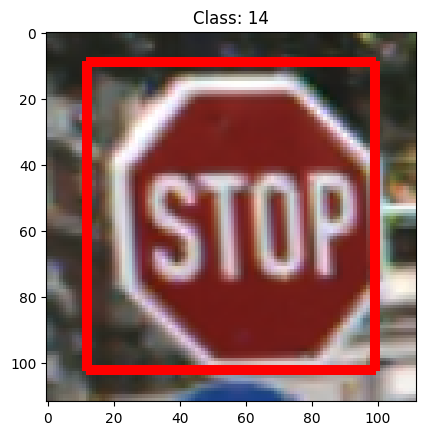

In [10]:
img, class_id, bbox = val[1]
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0).numpy()
else:
    img = img

bnd_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_img)
plt.title('Class: '+ str(class_id));

**Define classification model**

In [11]:
class ClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )

        self.layer6 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
        )

        self.layer7 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
                        nn.ReLU(inplace=True),
        )

        self.layer8 = nn.Sequential(
            nn.Linear(256, 43)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(x.shape[0], -1)

        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x

**Define model for classification + bbox**

In [12]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()

        self.bbox_regression_branch = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)

        self.classification_branch = ClassificationNet()


    def forward(self, images):

        classification_output = self.classification_branch(images)

        bbox_output = self.bbox_regression_branch(images)

        return classification_output, bbox_output

In [13]:
model = CombinedModel()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

**Loss + Optimizer**

In [14]:
classification_loss = nn.CrossEntropyLoss()
bbox_loss = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

**Training + Validation**

In [15]:
# init loss to compare and save best model later
best_val_loss = float('inf')
best_model_weights = None

epochs = 4
for epoch in range(1, epochs + 1):

    # training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_with_progress = tqdm(train_loader, desc=f'[TRAIN] Epoch {epoch}/{epochs}')

    for images, labels, bboxes in train_loader_with_progress:
        classification_output, bbox_output = model(images)

        classification_loss_value = classification_loss(classification_output, labels)
        bbox_loss_value = bbox_loss(bbox_output, bboxes)
        total_loss = classification_loss_value + bbox_loss_value

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        _, predicted = torch.max(classification_output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        accuracy_train = correct_train / total_train

        postfix_dict = {'classification loss': classification_loss_value.item(), 'bbox loss': bbox_loss_value.item(), 'classification acc': accuracy_train }
        train_loader_with_progress.set_postfix(postfix_dict)

    # validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_with_progress = tqdm(val_loader, desc=f'[VALID] Epoch {epoch}/{epochs}')

    with torch.no_grad():
        for images, labels, bboxes in val_loader_with_progress:
            classification_output, bbox_output = model(images)

            classification_loss_value = classification_loss(classification_output, labels)
            bbox_loss_value = bbox_loss(bbox_output, bboxes)

            total_loss = classification_loss_value + bbox_loss_value

            val_loss += total_loss.item()
            _, predicted = torch.max(classification_output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            accuracy_val = correct_val / total_val

            postfix_dict2 = {'classification loss': classification_loss_value.item(), 'bbox loss': bbox_loss_value.item(), 'classification acc': accuracy_val }
            val_loader_with_progress.set_postfix(postfix_dict2)

    val_loss /= len(val_loader)

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()

torch.save(best_model_weights, 'best_model_weights.pt')


[VALID] Epoch 4/4: 100%|██████████| 246/246 [04:12<00:00,  1.03s/it, classification loss=0.0234, bbox loss=1.3, classification acc=0.985]


**Load best model**

In [16]:
model = CombinedModel()

model.load_state_dict(torch.load('best_model_weights.pt'))

model.eval()

CombinedModel(
  (bbox_regression_branch): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
      

In [17]:
def display_image(image_tensor, classification_output, bbox_output, actual_class, actual_bbox):

    image = np.array(image_tensor.cpu())
    image = np.transpose(image, (1, 2, 0))  # (c, h, w) -> (h, w, c)

    classification_output = classification_output.cpu().squeeze().numpy()
    bbox_output = bbox_output.cpu().squeeze().numpy()
    actual_bbox = actual_bbox.cpu().squeeze().numpy()
    plt.imshow(image)
    plt.axis('off')

    predicted_bbox = plt.Rectangle((bbox_output[0],
                                    bbox_output[1]),
                                    bbox_output[2] - bbox_output[0],
                                    bbox_output[3] - bbox_output[1],
                                    linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(predicted_bbox)

    actual_bbox_rect = plt.Rectangle((actual_bbox[0],
                                      actual_bbox[1]),
                                      actual_bbox[2] - actual_bbox[0],
                                      actual_bbox[3] - actual_bbox[1],
                                      linewidth=2, edgecolor='g', facecolor='none')
    plt.gca().add_patch(actual_bbox_rect)

    plt.title(f'Predicted: {np.argmax(classification_output)}', color='red', loc='left')
    plt.title(f' Actual: {actual_class}', color='green', loc='right')

    plt.show()

In [18]:
classes = {
    0: 'Speed limit (20km/h)',            1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',            3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',            5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',     7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',           9: 'No passing',
    10: 'No passing veh over 3.5 tons',   11: 'Right-of-way at intersection',
    12: 'Priority road',                  13: 'Yield',
    14: 'Stop',                           15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',      17: 'No entry',
    18: 'General caution',                19: 'Dangerous curve left',
    20: 'Dangerous curve right',          21: 'Double curve',
    22: 'Bumpy road',                     23: 'Slippery road',
    24: 'Road narrows on the right',      25: 'Road work',
    26: 'Traffic signals',                27: 'Pedestrians',
    28: 'Children crossing',              29: 'Bicycles crossing',
    30: 'Beware of ice/snow',             31: 'Wild animals crossing',
    32: 'End speed + passing limits',     33: 'Turn right ahead',
    34: 'Turn left ahead',                35: 'Ahead only',
    36: 'Go straight or right',           37: 'Go straight or left',
    38: 'Keep right',                     39: 'Keep left',
    40: 'Roundabout mandatory',           41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

**See predicted vs actual**

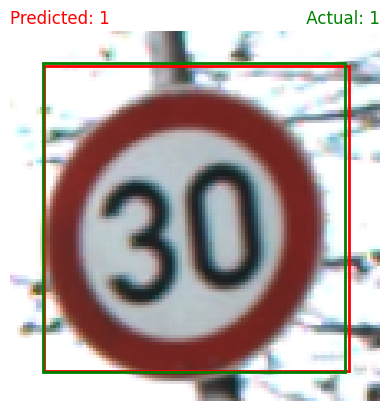

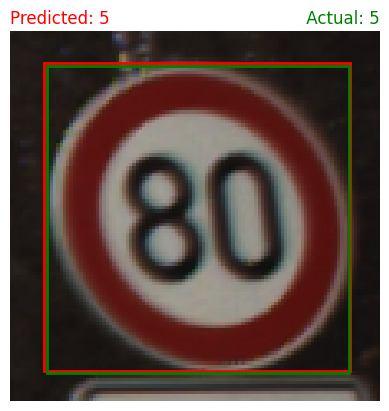

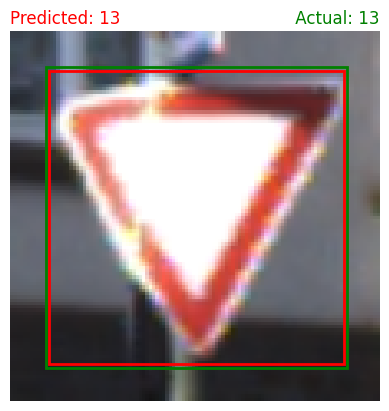

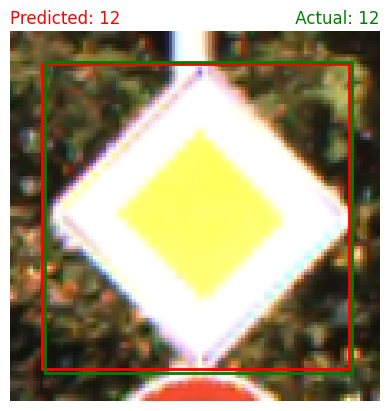

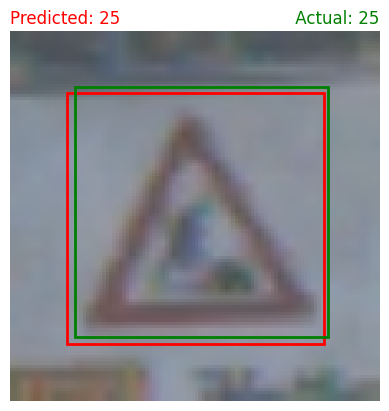

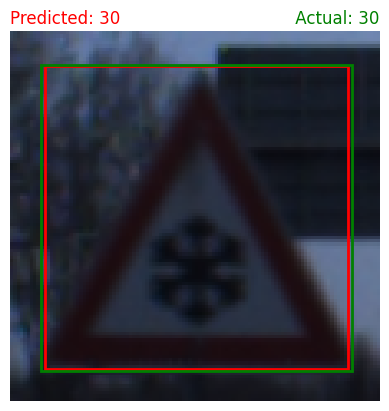

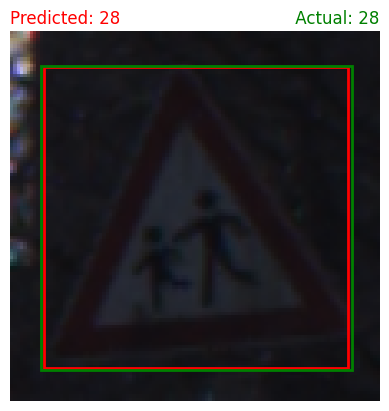

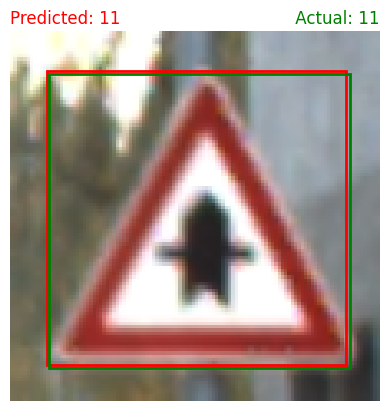

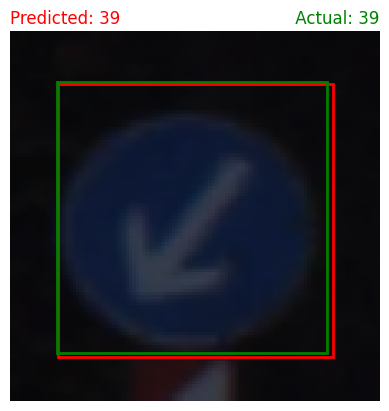

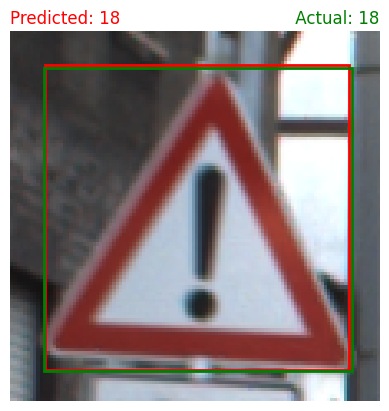

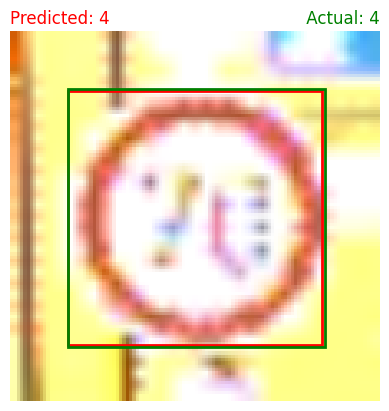

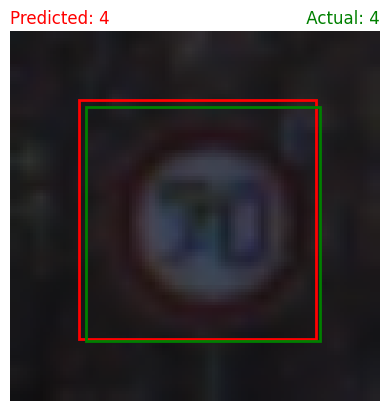

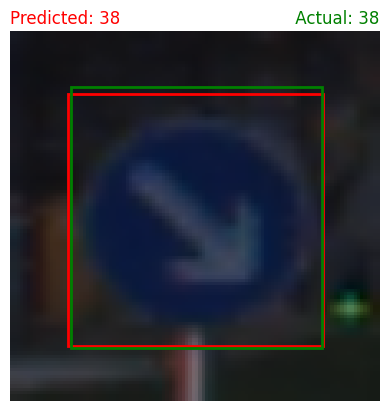

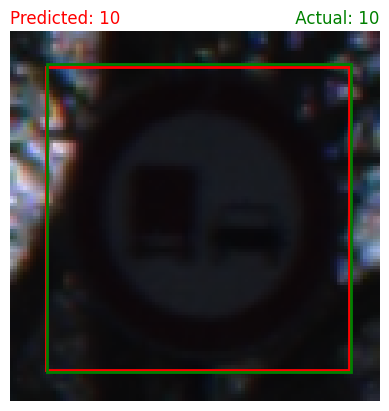

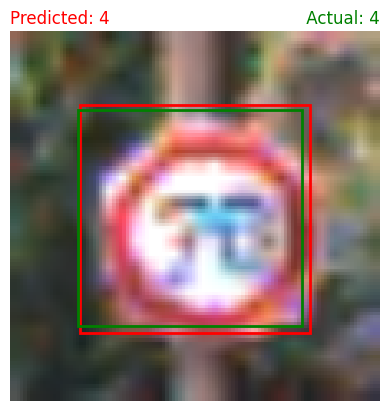

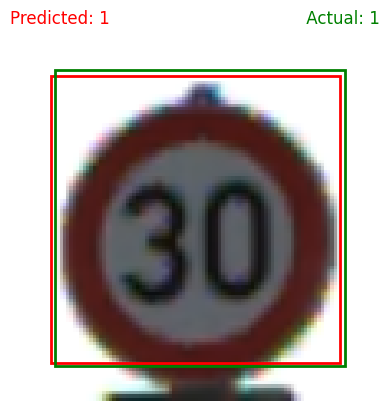

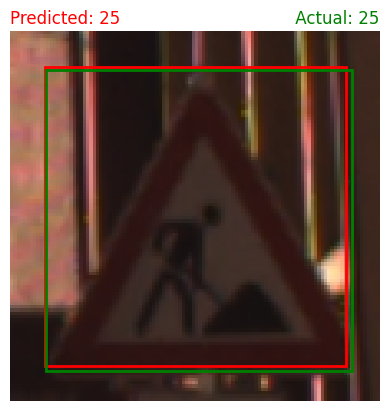

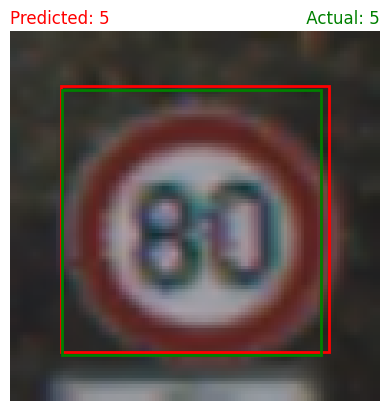

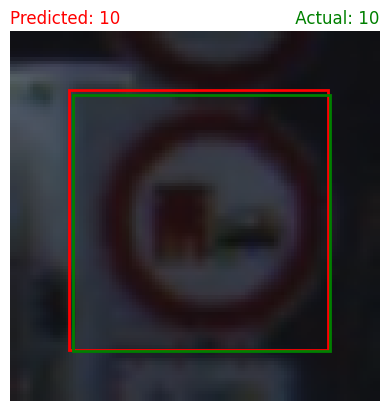

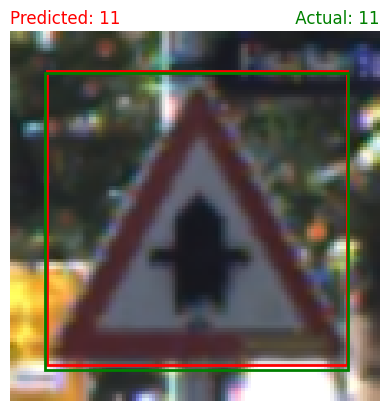

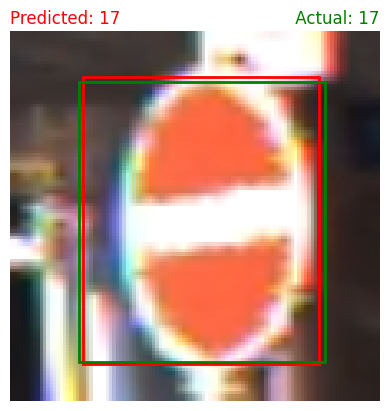

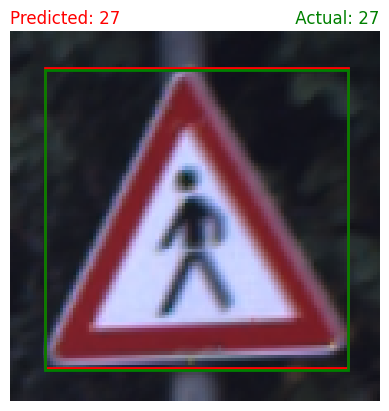

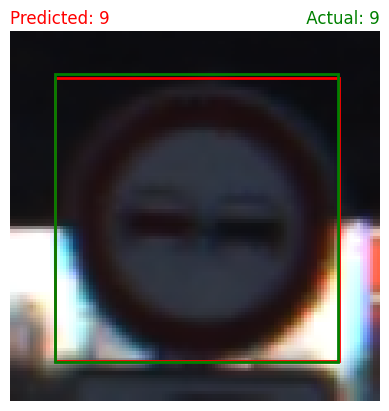

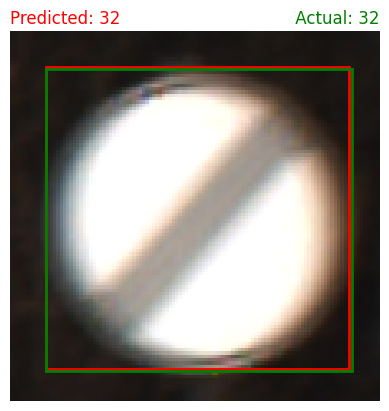

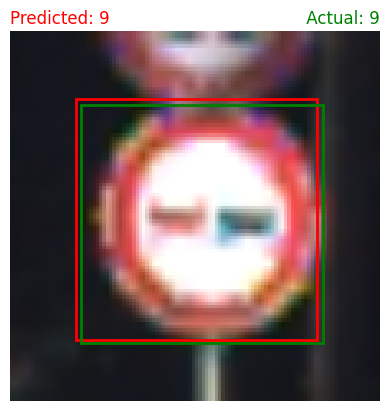

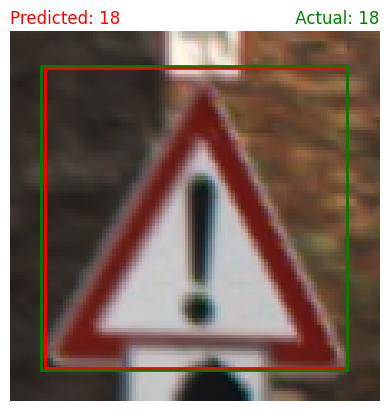

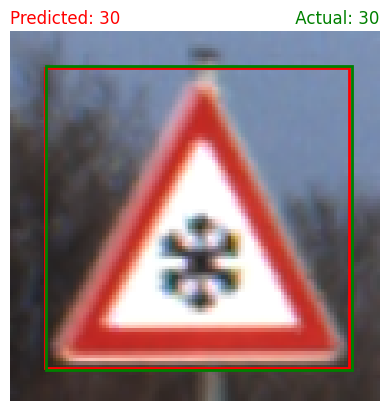

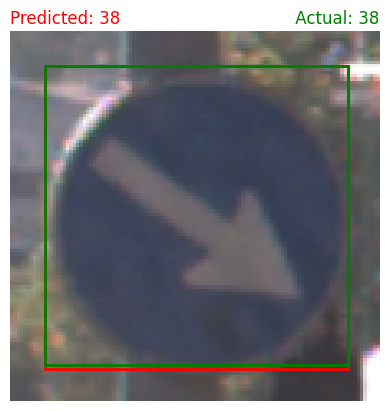

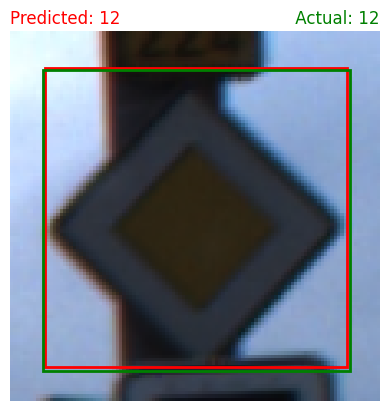

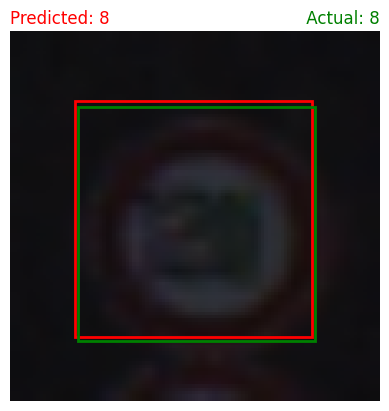

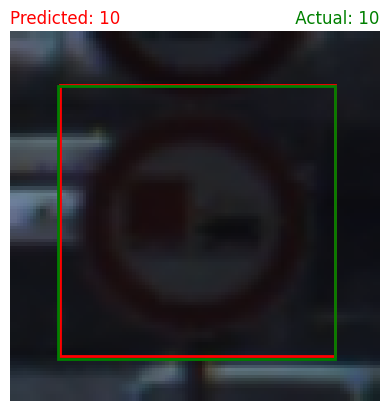

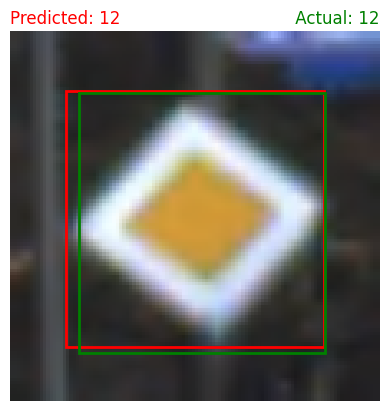

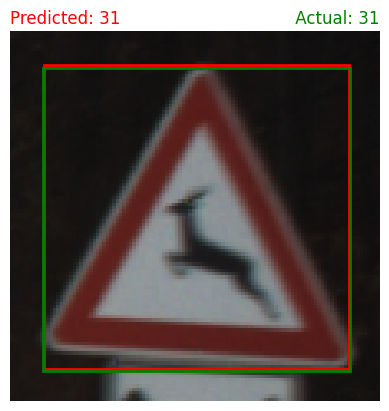

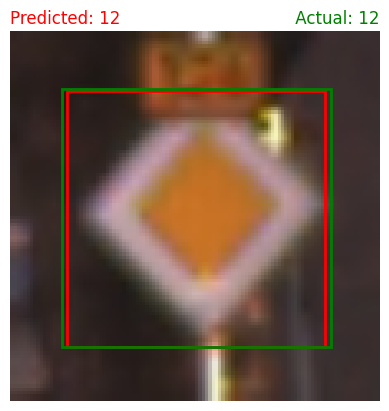

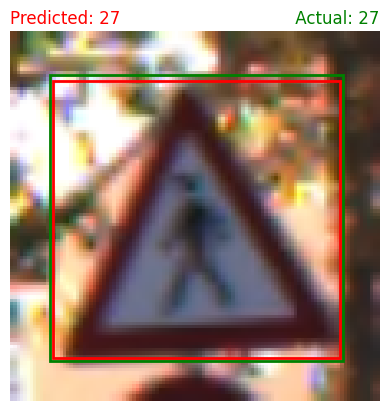

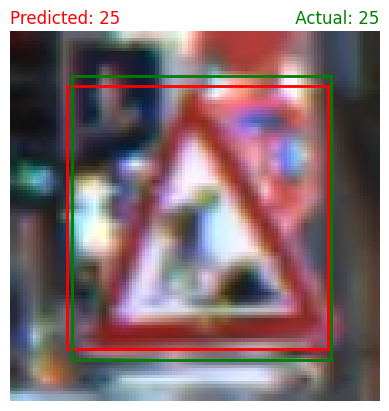

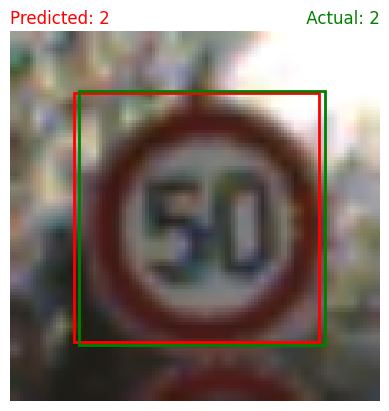

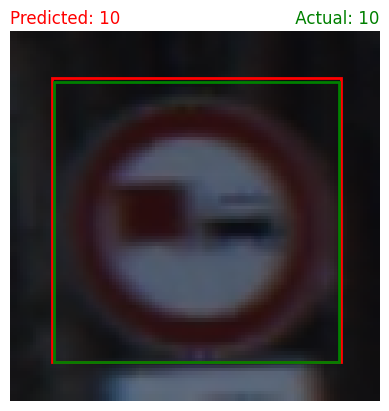

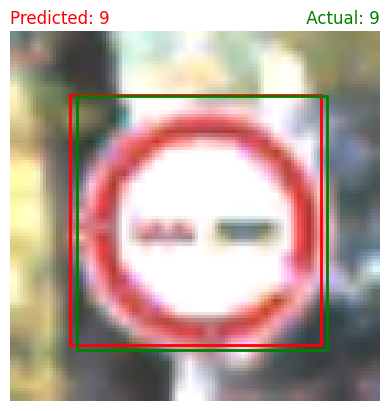

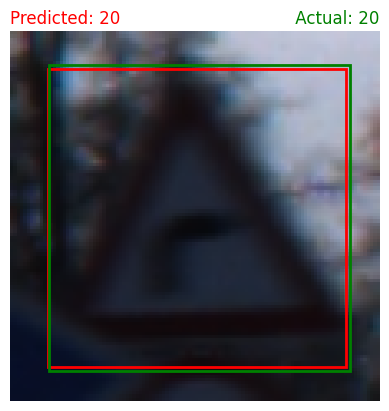

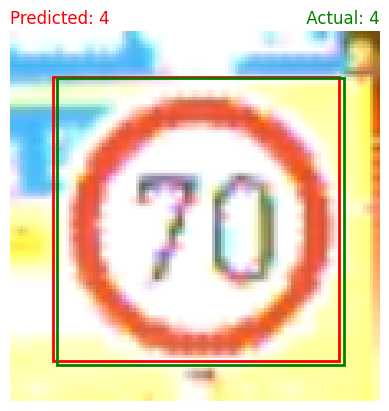

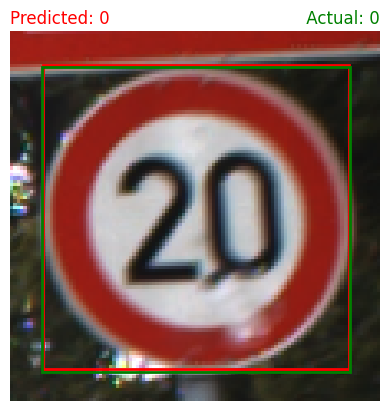

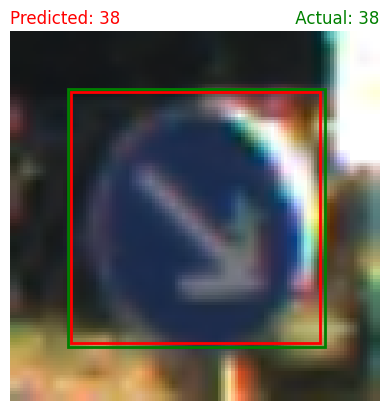

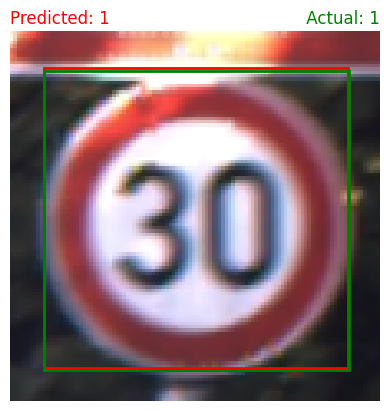

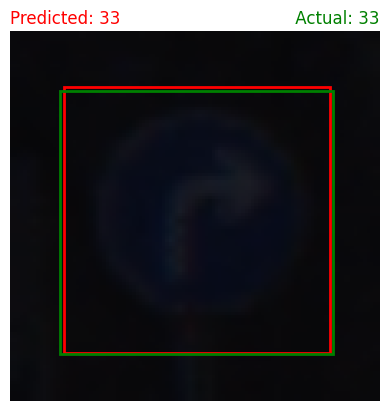

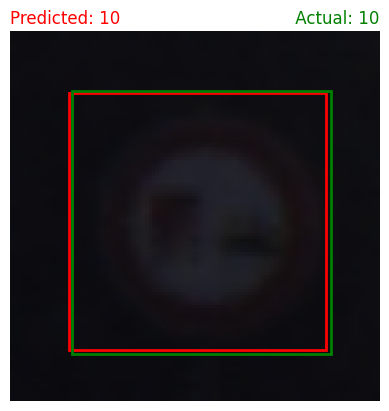

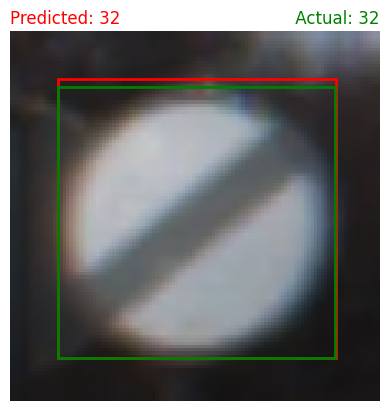

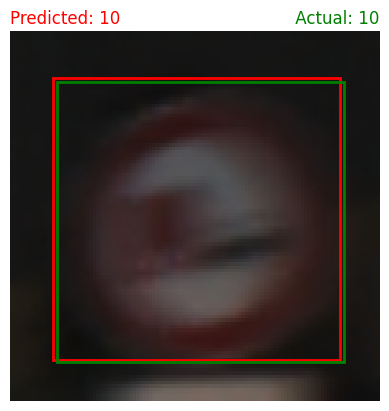

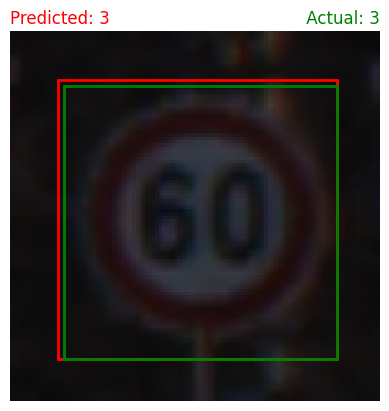

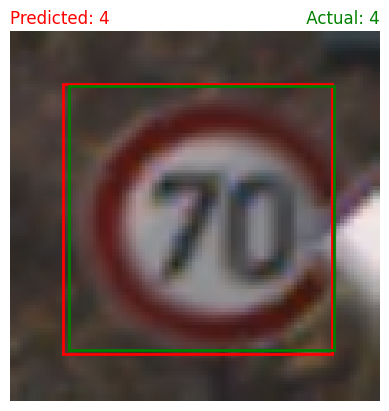

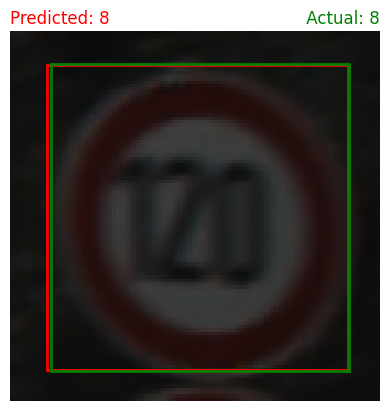

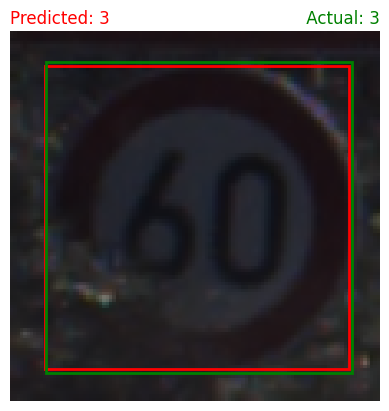

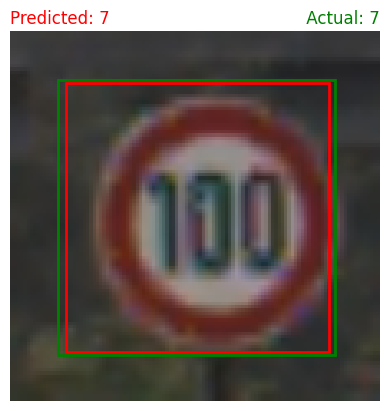

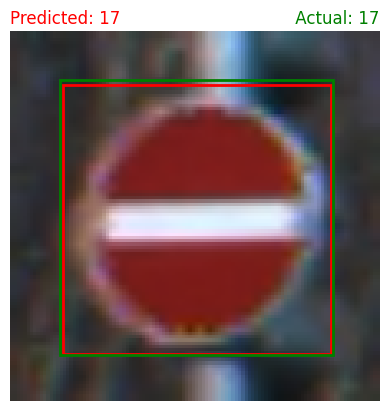

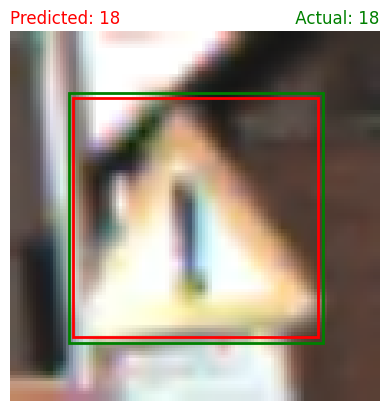

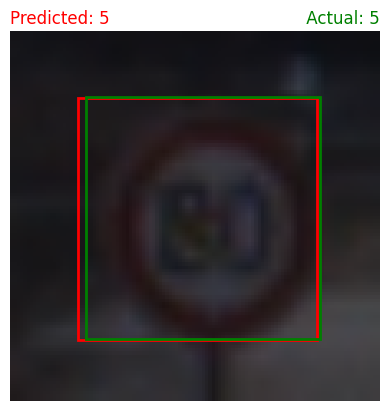

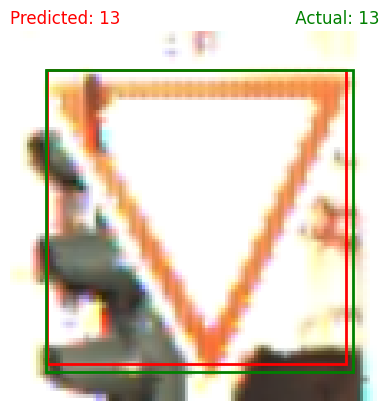

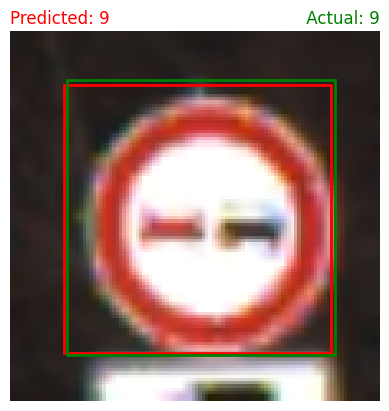

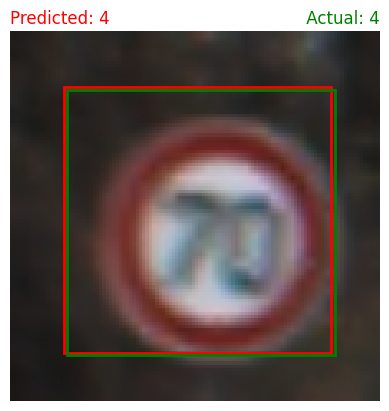

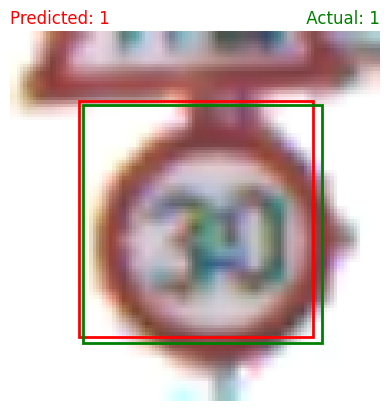

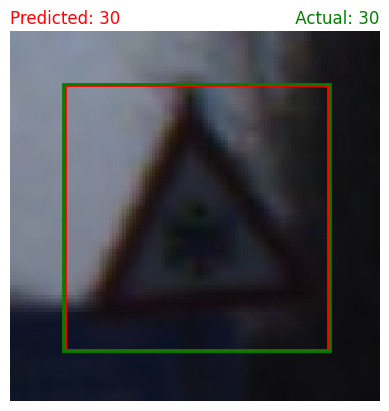

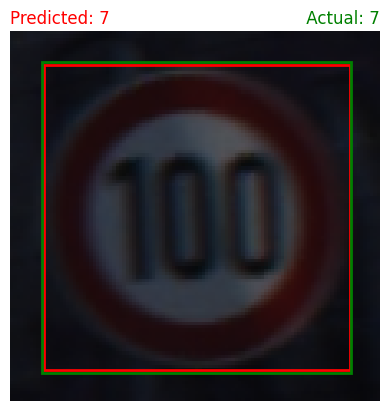

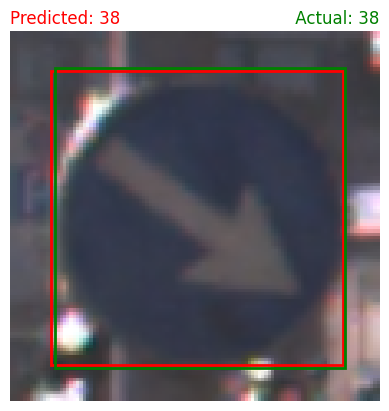

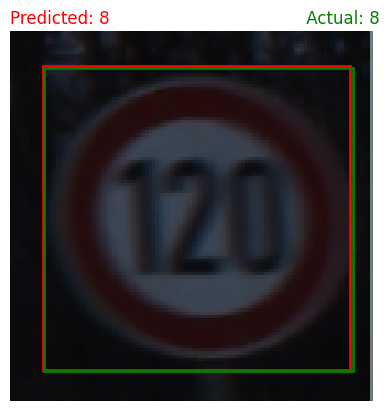

In [20]:
num_samples = len(val_loader.dataset)
random_indices = random.sample(range(num_samples), 25) # show X amount of random pics

for idx, (images, labels, bboxes) in enumerate(val_loader):
    if idx in random_indices:
        images = images
        labels = labels
        bboxes = bboxes

        with torch.no_grad():
            classification_output, bbox_output = model(images)

        for i in range(len(images)):
            image = images[i]
            actual_class = labels[i]
            actual_bbox = bboxes[i]

            display_image(image, classification_output[i], bbox_output[i], actual_class, actual_bbox)